In [47]:
import tensorflow as tf
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from yahoo_fin import stock_info as si
from datetime import datetime
from utils_tensorflow import *

mpl.rcParams['figure.figsize'] = (16, 6)
mpl.rcParams['axes.grid'] = False

tf.random.set_seed(13)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Using TensorFlow backend.


In [5]:
ticker = 'AAPL'
HISTORY_START_DATE = '2012-01-01'

df = si.get_data(ticker)
df = df[df.index >= HISTORY_START_DATE]
df['adjclose'].dropna(inplace=True)

In [6]:
df.tail()

,open,high,low,close,adjclose,volume,ticker
2020-05-18,313.170013,316.500000,310.320007,314.959991,314.959991,33843100.0,AAPL
2020-05-19,315.029999,318.519989,313.010010,313.140015,313.140015,25432400.0,AAPL
2020-05-20,316.679993,319.519989,316.519989,319.230011,319.230011,27876200.0,AAPL
2020-05-21,318.660004,320.890015,315.869995,316.850006,316.850006,25672200.0,AAPL
2020-05-22,315.769989,319.230011,315.350006,318.890015,318.890015,20430600.0,AAPL


In [7]:
df.shape

(2111, 7)

Let's observe how this data looks across time.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000020C6829C908>],
      dtype=object)

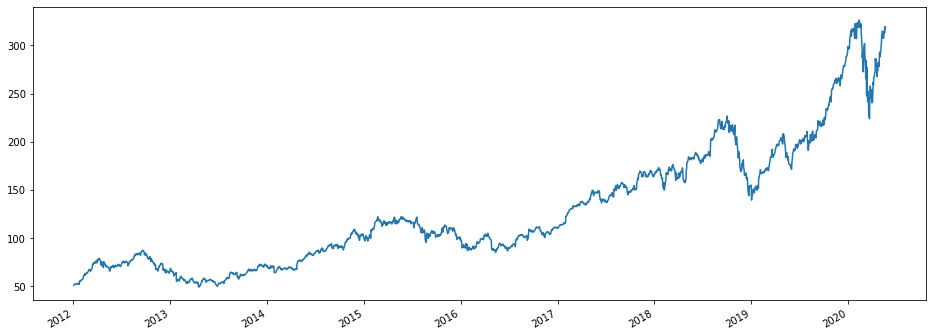

In [8]:
df['adjclose'].plot(subplots=True)

## Part 2: Forecast a multivariate time series

The original dataset contains fourteen features. For simplicity, this section considers only three of the original fourteen. The features used are air temperature, atmospheric pressure, and air density. 

To use more features, add their names to this list.

In [9]:
features_considered = ['open', 'high', 'low', 'close', 'adjclose', 'volume']

In [10]:
features = df[df['open'].isna()==False][features_considered]
features = features[features.index > '2012-01-01']
features.head()

,open,high,low,close,adjclose,volume
2012-01-03,58.485714,58.928570,58.428570,58.747143,50.857235,75555200.0
2012-01-04,58.571430,59.240002,58.468571,59.062859,51.130558,65005500.0
2012-01-05,59.278572,59.792858,58.952858,59.718571,51.698215,67817400.0
2012-01-06,59.967144,60.392857,59.888573,60.342857,52.238651,79573200.0
2012-01-09,60.785713,61.107143,60.192856,60.247143,52.155792,98506100.0


Let's have a look at how each of these features vary across time.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000020C67E99748>,
      dtype=object)

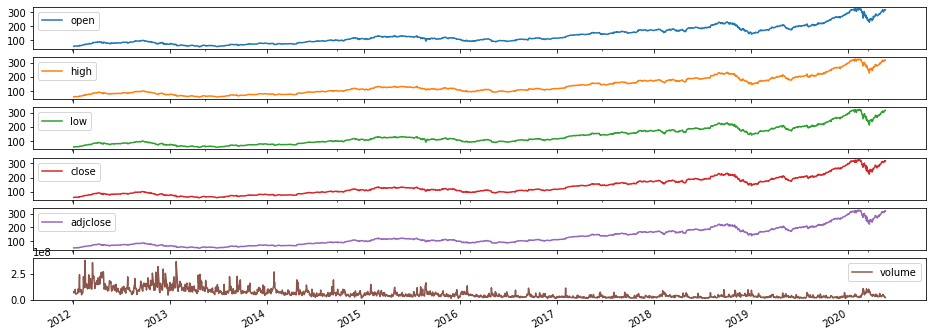

In [11]:
features.plot(subplots=True)

As mentioned, the first step will be to standardize the dataset using the mean and standard deviation of the training data.

In [16]:
dataset = features.values

TRAIN_SPLIT = int(df.shape[0] * 0.75)
print(f"TRAIN_SPLIT: {TRAIN_SPLIT}, TEST SPLIT: {df.shape[0] - TRAIN_SPLIT}")

scaler = MinMaxScaler()
scaler.fit(dataset[:TRAIN_SPLIT])

dataset = scaler.transform(dataset)

TRAIN_SPLIT: 1583, TEST SPLIT: 528


### Multi-Step model
In a multi-step prediction model, given a past history, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predict a sequence of the future.

For the multi-step model, the training data again consists of recordings over the past five days sampled every hour. However, here, the model needs to learn to predict the temperature for the next 12 hours. Since an obversation is taken every 10 minutes, the output is 72 predictions. For this task, the dataset needs to be prepared accordingly, thus the first step is just to create it again, but with a different target window.

In [36]:
past_history = 50
future_target = 14
BATCH_SIZE = 64
BUFFER_SIZE = 1000

train_data = prepare_batches(dataset, dataset[:, 1],
                             0, TRAIN_SPLIT,
                             past_history, future_target)
val_data = prepare_batches(dataset, dataset[:, 1],
                           TRAIN_SPLIT, None,
                           past_history, future_target)

Let's check out a sample data-point.

In [37]:
dates = df.index[df.index > HISTORY_START_DATE]
dates = np.array(dates.date, 'str')

train_dates = prepare_dates(dates, 0, TRAIN_SPLIT, 
                            past_history, future_target)

val_dates = prepare_dates(dates, TRAIN_SPLIT, None, 
                          past_history, future_target)

In [38]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('Target to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (50, 6)
Target to predict : (14,)


In [39]:
# train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
# train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

# val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
# val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

Plotting a sample data-point.

In [56]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'b-o',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'r-o',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

In this plot and subsequent similar plots, the history and the future data are sampled every hour.

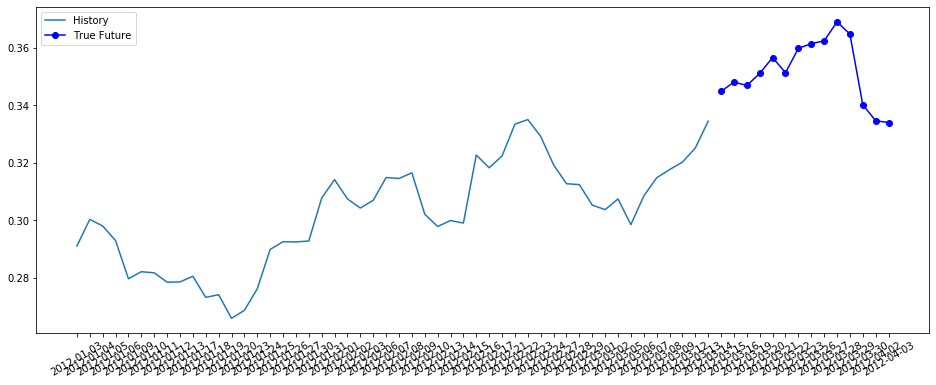

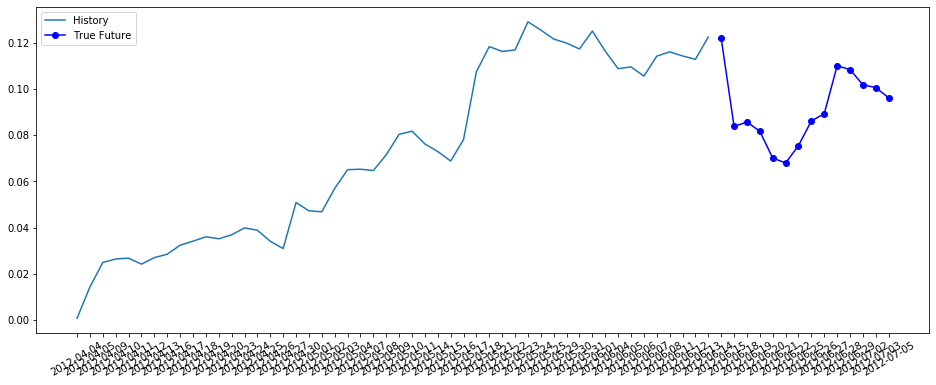

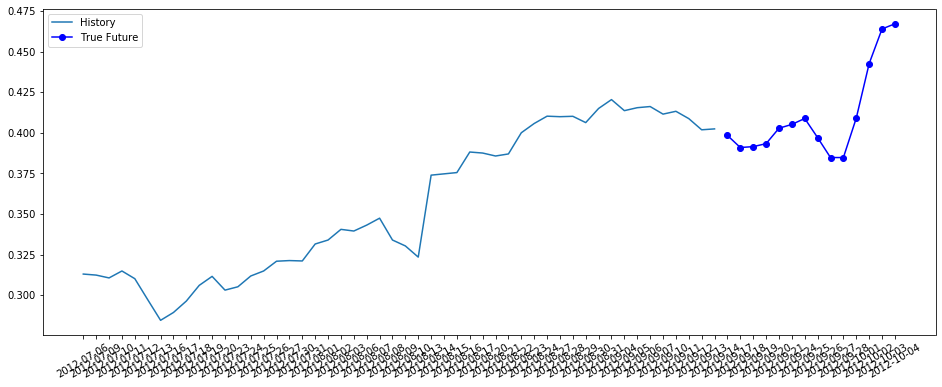

In [46]:
for xy, date in zip(train_data.take(3), train_dates.take(3)):
    
    x, y = xy
    x_dates, y_dates = date
    history = np.array(x[0])
    true_future = np.array(y[0])
#     print(history)
    
    multi_step_plot_dates(x_dates[0].numpy(), history, y_dates[0].numpy(), true_future)

Since the task here is a bit more complicated than the previous task, the model now consists of two LSTM layers. Finally, since 72 predictions are made, the dense layer outputs 72 predictions.

In [48]:
x_train_multi.shape[-2:]

(50, 6)

In [49]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(64,
                                          return_sequences=True,
                                          input_shape=(50, 6)))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(future_target))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

Let's see how the model predicts before it trains.

In [50]:
for x, y in val_data_multi.take(1):
    print (multi_step_model.predict(x).shape)

(64, 14)


In [ ]:
early_stopping = EarlyStopping(patience=10, monitor="val_loss", restore_best_weights=True)

multi_step_history = multi_step_model.fit(train_data_multi, epochs=100,
                                          steps_per_epoch=1000,
                                          validation_data=val_data_multi,
                                          validation_steps=50,
                                          callbacks=[early_stopping])

Train for 1000 steps, validate for 50 steps
Epoch 1/100
 794/1000 [======================>.......] - ETA: 7s - loss: 0.0251

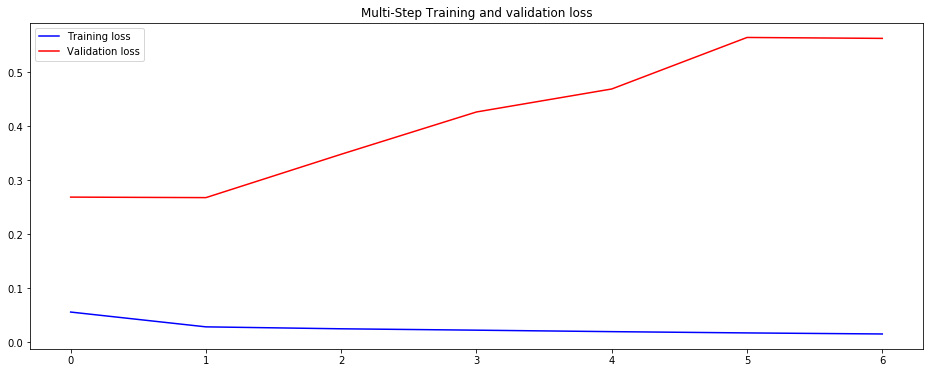

In [52]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

#### Predict a multi-step future
Let's now have a look at how well your network has learnt to predict the future.

In [ ]:
for xy, date in zip(val_data.take(3), val_dates.take(3)):
    
    x, y = xy
    x_dates, y_dates = date
    history = np.array(x[0])
    true_future = np.array(y[0])
    prediction = np.array(multi_step_model.predict(x)[0])
    
    multi_step_plot_dates(x_dates[0].numpy(), history, y_dates[0].numpy(), true_future, prediction)